In [28]:
import pandas as pd
import category_encoders as ce
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import seaborn as sns
import matplotlib as mlb
import matplotlib.image as mpimg
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor

import plotly.express as px
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn import  metrics


from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor

import xgboost as xgb
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from IPython.display import display
import os
#plt.style.use("seaborn")
%matplotlib inline  
import warnings
warnings.filterwarnings("ignore")

In [29]:
data = pd.read_csv(r'cac_dataset/customer_acquisition_costs.csv')
data_label = data["cost"]

In [30]:

train_data = pd.read_csv(r'cac_dataset/customer_acquisition_costs.csv')
train_data = train_data.drop(["avg_cars_at home(approx).1"], axis=1)
train_label = train_data["cost"]
train_data = train_data.drop(["cost"], axis=1)
train_data["avg. yearly_income"] = train_data['avg. yearly_income'].str.replace(r'\$', '', regex=True) #cleaned yearly income
def media_cleaner(value):
    if 'Daily' in value:
        value = "Daily Media"
    elif 'Sunday' in value:
        value = "Sunday Media"
    return value
train_data["media_type"] = train_data["media_type"].apply(media_cleaner) #cleaned mediatype

# Map the data value to strength score
education_mapping = {
    "Partial High School": 1,
    "High School Degree": 2,
    "Partial College": 3,
    "Bachelors Degree": 4,
    "Graduate Degree": 5
}

houseowner_mapping = {"Y": 1, "N": 0}

occupation_mapping = {'Manual' :1,
                    'Skilled Manual':2,
                    'Clerical':3,
                    'Professional':4,
                    'Management':5}

member_card_mapping = {
    "Normal": 1,
    "Bronze": 2,
    "Silver": 3,
    "Golden": 4
}
income_mapping = {
    "10K - 30K": 1,
    "30K - 50K": 2,
    "50K - 70K": 3,
    "70K - 90K": 4,
    "90K - 110K": 5,
    "110K - 130K": 6,
    "130K - 150K": 7,
    "150K +": 8
}
car_mapping = {
    "0 car": 0.0,
    "1 car": 1.0,
    "2 car": 2.0,
    "3 car": 3.0,
    "4 car": 4.0
}

weights = {
    "education_encoded": 0.1,
    "houseowner_encoded": 0.15,
    "member_card_encoded": 0.2,
    "income_encoded": 0.3, 
    "occupation_encoded": 0.1,
    "cars_at_home" : 0.15
}

train_data["profile_strength"] = (
    (train_data["education"].map(education_mapping)) * weights["education_encoded"] +
    (train_data["houseowner"].map(houseowner_mapping)) * weights["houseowner_encoded"] +
    (train_data["member_card"].map(member_card_mapping)) * weights["member_card_encoded"] +
    (train_data["avg. yearly_income"].map(income_mapping)) * weights["income_encoded"] +
    (train_data["occupation"].map(occupation_mapping)) * weights["occupation_encoded"] +
    (train_data["avg_cars_at home(approx)"]) * weights["cars_at_home"] 
) 

ordinal_cat = ["education","occupation","member_card","avg. yearly_income","store_type"]
dic = {}
for i in range(len(ordinal_cat)):
    dic[ordinal_cat[i]] = train_data[ordinal_cat[i]].unique()


codes = [0,1,2,3,4,5,6,7]
ed_map = pd.DataFrame({"education" : ["Partial High School","High School Degree","Partial College","Bachelors Degree","Graduate Degree"],
                       "encoding_values" : codes[:5]})
mem_map = pd.DataFrame({"member_card":["Normal","Bronze","Silver","Golden"],
                        "encoding_values" : codes[:4]})
occ_map = pd.DataFrame({"occupation" : ['Manual', 'Skilled Manual', 'Clerical', 'Professional', 'Management'],
                       "encoding_values" : codes[:5]})
inc_map = pd.DataFrame({"avg. yearly_income" :['10K - 30K', '30K - 50K', '50K - 70K', '70K - 90K','90K - 110K', '110K - 130K', '130K - 150K', '150K +'],
                        "encoding_values" : codes})
store_map = pd.DataFrame({"store_type":['Small Grocery', 'Mid-Size Grocery', 'Supermarket', 'Gourmet Supermarket', 'Deluxe Supermarket'],
                         "encoding_values" : codes[:5]})

ordinal_order = [ed_map[ordinal_cat[0]],occ_map[ordinal_cat[1]],mem_map[ordinal_cat[2]],inc_map[ordinal_cat[3]],store_map[ordinal_cat[4]]]

for i in range(len(ordinal_order)):
    train_data[ordinal_cat[i]] = pd.Categorical(train_data[ordinal_cat[i]], categories=ordinal_order[i], ordered=True).codes


nominal_cat = train_data.select_dtypes('object').columns



# Apply binary encoding
binary_encoder = ce.BinaryEncoder(cols=nominal_cat)
train_encoded = binary_encoder.fit_transform(train_data)

def get_stats(data,col):
    data_column = data[col]
    op_mean = np.mean(data_column)
    op_median = np.median(data_column)
    op_std = np.std(data_column)
    op_var = np.var(data_column)
    op_min = np.min(data_column)
    op_max = np.max(data_column)
    op_1q = data_column.quantile(0.25)
    op_3q = data_column.quantile(0.75)
    op_iqr = op_3q - op_1q
    op_upper = min((op_3q + 1.5*(op_iqr)),data_column.max())
    op_lower = max((op_1q - 1.5*(op_iqr)),data_column.min())
    op_outliers = ((data_column < op_lower) | (data_column > op_upper)).sum()
    dic_stats = {"Mean": [op_mean],
                "Median":[op_median],
                "Standard-Deviation": [op_std],
                "Variance": [op_var],
                "Minimum Value": [op_min],
                "Maximum Value": [op_max],
                "Q1": [op_1q],
                "Q3": [op_3q],
                "IQR": [op_iqr],
                "Upper Fence":[op_upper],
                "Lower Fence": [op_lower],
                "Outliers count":[op_outliers]}

    return dic_stats

dic_sales = get_stats(train_encoded, "store_sales(in millions)") 
train_encoded["store_sales(in millions)"] = np.where(train_encoded["store_sales(in millions)"] > dic_sales["Upper Fence"][0], dic_sales["Upper Fence"][0], (np.where(train_encoded["store_sales(in millions)"] < dic_sales["Lower Fence"][0], dic_sales["Lower Fence"][0], train_encoded["store_sales(in millions)"])))

dic_cost = get_stats(train_encoded, "store_cost(in millions)") 
train_encoded["store_cost(in millions)"] = np.where(train_encoded["store_cost(in millions)"] > dic_cost["Upper Fence"][0], dic_cost["Upper Fence"][0], (np.where(train_encoded["store_cost(in millions)"] < dic_cost["Lower Fence"][0], dic_cost["Lower Fence"][0], train_encoded["store_cost(in millions)"])))


In [31]:
scaler = MinMaxScaler()
X = scaler.fit_transform(train_encoded)
y = train_label.values
model = RandomForestRegressor(n_estimators=200)
model.fit(X, y)
importances = model.feature_importances_
final_df = pd.DataFrame({'Features': train_encoded.columns, 'Importances': importances})

<Axes: >

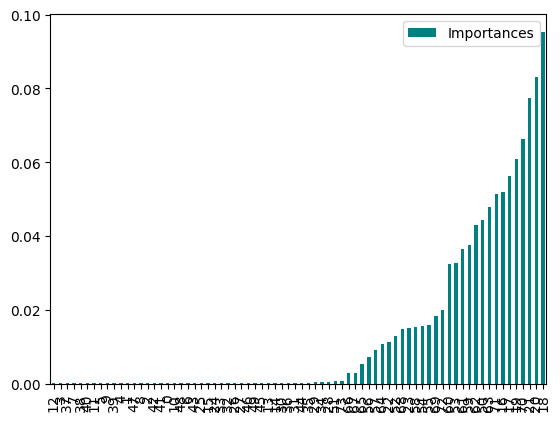

In [32]:
final_df = final_df.sort_values('Importances')
final_df.plot.bar(color='teal')

In [33]:
final_df

,Features,Importances
12,food_family_1,0.000010
3,food_category_3,0.000010
37,brand_name_0,0.000010
7,food_department_1,0.000010
38,brand_name_1,0.000012
...,...,...
19,promotion_name_3,0.060857
70,media_type_1,0.066283
21,promotion_name_5,0.077424
20,promotion_name_4,0.083164


In [34]:
final_part_df = list(final_df[final_df["Importances"]>0.001]["Features"])

In [35]:
final_part_df

['salad_bar',
 'prepared_food',
 'video_store',
 'store_state_0',
 'store_state_1',
 'coffee_bar',
 'sales_country_0',
 'store_city_1',
 'florist',
 'sales_country_1',
 'store_state_2',
 'store_city_3',
 'store_city_4',
 'media_type_0',
 'media_type_3',
 'store_sqft',
 'store_city_2',
 'grocery_sqft',
 'store_state_3',
 'frozen_sqft',
 'store_type',
 'meat_sqft',
 'media_type_2',
 'promotion_name_0',
 'promotion_name_1',
 'promotion_name_3',
 'media_type_1',
 'promotion_name_5',
 'promotion_name_4',
 'promotion_name_2']

In [ ]:
train_data = pd.read_csv(r'cac_dataset/customer_acquisition_costs.csv')

In [ ]:
def preprocessor(X, split):
    X = X.drop(["avg_cars_at home(approx).1"], axis=1)
    X["avg. yearly_income"] = X['avg. yearly_income'].str.replace(r'\$', '', regex=True)

    def media_cleaner(value):
        if 'Daily' in value:
            value = "Daily Media"
        elif 'Sunday' in value:
            value = "Sunday Media"
        return value
    
    X["media_type"] = X["media_type"].apply(media_cleaner) 


    education_mapping = {"Partial High School": 1,"High School Degree": 2,"Partial College": 3,"Bachelors Degree": 4,"Graduate Degree": 5}
    houseowner_mapping = {"Y": 1, "N": 0}
    occupation_mapping = {'Manual' :1,'Skilled Manual':2,'Clerical':3,'Professional':4,'Management':5}
    member_card_mapping = {"Normal": 1,"Bronze": 2,"Silver": 3,"Golden": 4}
    income_mapping = {"10K - 30K": 1,"30K - 50K": 2,"50K - 70K": 3,"70K - 90K": 4,"90K - 110K": 5,"110K - 130K": 6,"130K - 150K": 7,"150K +": 8}
    car_mapping = {"0 car": 0.0,"1 car": 1.0,"2 car": 2.0,"3 car": 3.0,"4 car": 4.0}
    weights = {"education_encoded": 0.1,"houseowner_encoded": 0.15,"member_card_encoded": 0.2,"income_encoded": 0.3, "occupation_encoded": 0.1,"cars_at_home" : 0.15}
    X["profile_strength"] = (
        (X["education"].map(education_mapping)) * weights["education_encoded"] +
        (X["houseowner"].map(houseowner_mapping)) * weights["houseowner_encoded"] +
        (X["member_card"].map(member_card_mapping)) * weights["member_card_encoded"] +
        (X["avg. yearly_income"].map(income_mapping)) * weights["income_encoded"] +
        (X["occupation"].map(occupation_mapping)) * weights["occupation_encoded"] +
        (X["avg_cars_at home(approx)"]) * weights["cars_at_home"] 
    ) 
    ordinal_cat = ["education","occupation","member_card","avg. yearly_income","store_type"]


    codes = [0,1,2,3,4,5,6,7]
    ed_map = {"education" : ["Partial High School","High School Degree","Partial College","Bachelors Degree","Graduate Degree"],"encoding_values" : codes[:5]}
    mem_map = {"member_card":["Normal","Bronze","Silver","Golden"],"encoding_values" : codes[:4]}
    occ_map = {"occupation" : ['Manual', 'Skilled Manual', 'Clerical', 'Professional', 'Management'],"encoding_values" : codes[:5]}
    inc_map = {"avg. yearly_income" :['10K - 30K', '30K - 50K', '50K - 70K', '70K - 90K','90K - 110K', '110K - 130K', '130K - 150K', '150K +'],"encoding_values" : codes}
    store_map = {"store_type":['Small Grocery', 'Mid-Size Grocery', 'Supermarket', 'Gourmet Supermarket', 'Deluxe Supermarket'],"encoding_values" : codes[:5]}
    ordinal_order = [ed_map[ordinal_cat[0]],occ_map[ordinal_cat[1]],mem_map[ordinal_cat[2]],inc_map[ordinal_cat[3]],store_map[ordinal_cat[4]]]
    for i in range(len(ordinal_order)):
        X[ordinal_cat[i]] = pd.Categorical(X[ordinal_cat[i]], categories=ordinal_order[i], ordered=True).codes

    def get_stats(data,col):
        data_column = data[col]
        op_mean = np.mean(data_column)
        op_median = np.median(data_column)
        op_std = np.std(data_column)
        op_var = np.var(data_column)
        op_min = np.min(data_column)
        op_max = np.max(data_column)
        op_1q = data_column.quantile(0.25)
        op_3q = data_column.quantile(0.75)
        op_iqr = op_3q - op_1q
        op_upper = min((op_3q + 1.5*(op_iqr)),data_column.max())
        op_lower = max((op_1q - 1.5*(op_iqr)),data_column.min())
        op_outliers = ((data_column < op_lower) | (data_column > op_upper)).sum()
        dic_stats = {"Mean": [op_mean],
                    "Median":[op_median],
                    "Standard-Deviation": [op_std],
                    "Variance": [op_var],
                    "Minimum Value": [op_min],
                    "Maximum Value": [op_max],
                    "Q1": [op_1q],
                    "Q3": [op_3q],
                    "IQR": [op_iqr],
                    "Upper Fence":[op_upper],
                    "Lower Fence": [op_lower],
                    "Outliers count":[op_outliers]}

        return dic_stats
    
    dic_sales = get_stats(X, "store_sales(in millions)") 
    X["store_sales(in millions)"] = np.where(X["store_sales(in millions)"] > dic_sales["Upper Fence"][0], dic_sales["Upper Fence"][0], (np.where(X["store_sales(in millions)"] < dic_sales["Lower Fence"][0], dic_sales["Lower Fence"][0], X["store_sales(in millions)"])))
    dic_cost = get_stats(X, "store_cost(in millions)") 
    X["store_cost(in millions)"] = np.where(X["store_cost(in millions)"] > dic_cost["Upper Fence"][0], dic_cost["Upper Fence"][0], (np.where(X["store_cost(in millions)"] < dic_cost["Lower Fence"][0], dic_cost["Lower Fence"][0],X["store_cost(in millions)"])))


    train, test = train_test_split(X,test_size=split,random_state=42,shuffle=True)
    X_train = train.drop("cost", axis=1)
    X_test = test.drop("cost", axis=1)
    y_train = train["cost"]
    y_test = test["cost"]
     

    nominal_cat = X_train.select_dtypes('object').columns
    binary_encoder = ce.BinaryEncoder(cols=nominal_cat)
    X_train = binary_encoder.fit_transform(X_train)
    X_test = binary_encoder.transform(X_test)

    scaler = MinMaxScaler()
    X_train = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index, columns=X_train.columns)
    X_test = pd.DataFrame(scaler.fit_transform(X_test), index=X_test.index, columns=X_test.columns)

    return X_train, X_test, y_train, y_test
    

In [39]:
data = pd.read_csv(r'cac_dataset/customer_acquisition_costs.csv')

In [40]:
split_size = 0.15
X_train, X_test, y_train, y_test = preprocessor(data, split_size)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((51363, 74), (9065, 74), (51363,), (9065,))

In [45]:
data.head()

,food_category,food_department,food_family,store_sales(in millions),store_cost(in millions),unit_sales(in millions),promotion_name,sales_country,marital_status,gender,...,grocery_sqft,frozen_sqft,meat_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,media_type,cost
0,Breakfast Foods,Frozen Foods,Food,7.36,2.7232,4.0,Bag Stuffers,USA,M,F,...,18670.0,5415.0,3610.0,1.0,1.0,1.0,1.0,1.0,"Daily Paper, Radio",126.62
1,Breakfast Foods,Frozen Foods,Food,5.52,2.5944,3.0,Cash Register Lottery,USA,M,M,...,18670.0,5415.0,3610.0,1.0,1.0,1.0,1.0,1.0,"Daily Paper, Radio",59.86
2,Breakfast Foods,Frozen Foods,Food,3.68,1.3616,2.0,High Roller Savings,USA,S,F,...,18670.0,5415.0,3610.0,1.0,1.0,1.0,1.0,1.0,"Daily Paper, Radio",84.16
3,Breakfast Foods,Frozen Foods,Food,3.68,1.1776,2.0,Cash Register Lottery,USA,M,F,...,18670.0,5415.0,3610.0,1.0,1.0,1.0,1.0,1.0,In-Store Coupon,95.78
4,Breakfast Foods,Frozen Foods,Food,4.08,1.4280,3.0,Double Down Sale,USA,M,M,...,18670.0,5415.0,3610.0,1.0,1.0,1.0,1.0,1.0,Radio,50.79


In [54]:
data[["unit_sales(in millions)","units_per_case"]]

,unit_sales(in millions),units_per_case
0,4.0,17.0
1,3.0,17.0
2,2.0,17.0
3,2.0,17.0
4,3.0,29.0
...,...,...
60423,1.0,26.0
60424,1.0,36.0
60425,2.0,26.0
60426,3.0,26.0


In [50]:
pd.DataFrame(data.columns)

,0
0,food_category
1,food_department
2,food_family
3,store_sales(in millions)
4,store_cost(in millions)
5,unit_sales(in millions)
6,promotion_name
7,sales_country
8,marital_status
9,gender


In [ ]:
data[data["sales_country"] == ""]["promotion_name"].unique()

array(['Save-It Sale', 'Super Duper Savers', 'Price Smashers',
       'I Cant Believe It Sale', 'Super Savers', 'Money Savers',
       'Double Down Sale', 'Bye Bye Baby', 'Green Light Special',
       'Price Cutters', 'Price Slashers', 'Savings Galore', 'Sales Days',
       'Double Your Savings', 'Shelf Clearing Days'], dtype=object)

In [55]:
data_predictor = pd.DataFrame(columns = data.columns)
data_predictor

,food_category,food_department,food_family,store_sales(in millions),store_cost(in millions),unit_sales(in millions),promotion_name,sales_country,marital_status,gender,...,grocery_sqft,frozen_sqft,meat_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,media_type,cost


In [ ]:
data